# Tutorial 8:Domain Adaptation 

## Introduction

In this tutorial, we will cover a following topics:

* Unsuprevised Domain Adaptation
* Semi-suprevised domain adaptation
* How are they related
* Pytorch implementation of unsuprevised domain adaptation approach  

## Unsupervised Domain adaptation by Backpropogation 
# <img src="un.png" width="1000" />


## Unsupervised Domain Adaptation Using Approximate Label Matching
# <img src="un2.png" width="500" />


## AutoDIAL: Automatic DomaIn Alignment Layers
# <img src="un3.png" width="1000" />


## AutoDial loss
a loss function $\mathcal{L}(\theta)=\mathcal{L}^s(\theta)+\lambda\mathcal{L}^t(\theta)$
where:
$$\mathcal{L}^s(\theta)=-\frac{1}{n}\sum^n_{i=1}\log f^\theta_s(y_i^s;x_i^s)  $$

$$\mathcal{L}^t(\theta)=-\frac{1}{m}\sum^m_{i=1}\sum_{y\in Y}f^\theta_t(y;x_i^t)\log f^\theta_t(y;x_i^t)  $$

## Semi-supervised domain adaptation 
When some labels are availible in the target daomain, then we can use these whem doing domain adapation.
I.e combine fine tunning and unsuprevised domain adaptation.

Tzeng et.al in "simultaneous deep transfer across domain tasks" take this a step futhet and try to simultaneously
optimaze a loss that maximizes:
* classification accuracy on both source and target datatsets 
* domain confusion of a domain calssifier 
* agreement of a classifier score distibution across domains 

# <img src="semi.png" width="1000" />


# <img src="semi2.png" width="1000" />


## Domain confussion loss
Alternate optimization of two objectives. First make domain classifier as good as possible
Standard binary cross entropy loss:
$$\mathcal{L}_D(x_S,x_T,\theta_{repr};\theta_D) = -\sum_d \chi[y_D=d] \log q_d$$
Second makes features as confusing as possible for the disciminator: 
$$\mathcal{L}_{conf}(x_S,x_T,\theta_D;\theta_{repr}) = -\sum_d \frac{1}{D} \log q_d$$

# <img src="semi3.png" width="1000" />

# <img src="semi4.png" width="1000" />

### Pytorch implementation of unsuprevised domain adaptation approach 

In [ ]:

import time
import numpy as np
from sklearn.metrics import accuracy_score

#import cv2
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from models import ALM
from data_handling import batch_generator, data_loader
from evaluation import plot_imgs


In [ ]:
# model parameters
print_interval = 200           # print example images every print_interval iterations
d_hidden_size = 100           # discriminator width
c_hidden_size = 50            # classifier width
d_learning_rate = 5e-5        # learning rate for discriminator
g_learning_rate = 5e-5        # learning rate for generator
c_learning_rate = 1e-3        # learning rate for classifier
l = 0.3                       # regularizer for adversarial loss
num_epochs = 4                # number of epochs to train models
clf_epochs = 4                # number of epochs to pretrain classifier
batch_size = 14               # size of image sample per epoch
source_data = 'mnist'         # mnist
target_data = 'mnist_m'       # mnist_m / usps
input_size = 3                # n_filters for target set; USPS has 1 greyscale filter
output_size = 3               # Transform to source set; MNIST has 1 greyscale filter
method = 'selective'          # default / selective / iterative


In [1]:


# load source domain dataset
(Xs_train, ys_train), (Xs_test, ys_test) = data_loader(source_data)
# # same lengths as USPS dataset
# (Xs_train, ys_train), (Xs_test, ys_test) = (Xs_train[:7291], ys_train[:7291]), (Xs_test[:2007], ys_test[:2007])
# concat MNIST images as channels to match number of MNIST-M channels
Xs_train = np.concatenate([Xs_train[:15000], Xs_train[:15000], Xs_train[:15000]], axis=1)
Xs_test = np.concatenate([Xs_test[:5000], Xs_test[:5000], Xs_test[:5000]], axis=1)
ys_train, ys_test = ys_train[:15000], ys_test[:5000]

# load target domain dataset
(Xt_train, yt_train), (Xt_test, yt_test) = data_loader(target_data)
(Xt_train, yt_train), (Xt_test, yt_test) = (Xt_train[:15000], yt_train[:15000]), (Xt_test[:5000], yt_test[:5000])

# instantiate the models
def ALM(input_ch, output_ch, d_hidden_size, c_hidden_size):
    g = alm_generator(input_ch=input_ch, output_ch=output_ch)
    d = alm_discriminator(input_ch=output_ch, hidden_size=d_hidden_size)
    c = alm_classifier(input_ch=output_ch, hidden_size=c_hidden_size)
    return g, d, c

G, D, C = ALM(input_size, output_size, d_hidden_size, c_hidden_size)

# define loss functions
bce_crit = nn.BCELoss() # binary crossentropy
mse_crit = nn.MSELoss() # mean squared error: used to minimize equation 1.

# set the optimizers
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(0.9, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(0.9, 0.999))
c_optimizer = optim.Adam(C.parameters(), lr=c_learning_rate, betas=(0.9, 0.999))

Using TensorFlow backend.


Loading MNIST data..
Loading MNIST_M data..


In [ ]:
# Pre-train the classifier on source dataset
print('Pre-training classifier model on {} dataset..'.format(source_data.upper()))
for epoch in range(clf_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, clf_epochs))
    
    # iterate over batches
       
    generator = batch_generator(batch_size, Xs_train, ys_train)
    for Xs, Ys, _ in generator:
        
        # reset gradients
        C.zero_grad()
        
        # get predictions from batch
        c_out = C(Xs)
        
        # forward and backward pass through classifier
        c_error = mse_crit(c_out, Ys.float())
        c_error.backward()
        c_optimizer.step()
    
    # evaluate on validation set
    Xstest = Variable(torch.from_numpy(Xs_test))
    Ystest = Variable(torch.from_numpy(ys_test))
    c_val_out = C(Xstest)
    c_val_error = mse_crit(c_val_out, Ystest.float())
    
    # print losses
    print(' - train_mse: {} - val_mse: {}'.format(format(c_error.data[0], '.4f'),
                                                format(c_val_error.data[0], '.4f')))

In [2]:


print('\nEvaluating classifier performance on {} and {} dataset..'.format(source_data.upper(), target_data.upper()))

# create approximate labels Ystar
Ystar = C(Variable(torch.from_numpy(Xt_train)))
t_classes = Ystar.max(1)[1].data.numpy().ravel()

# get subset of source test
Ys = C(Variable(torch.from_numpy(Xs_test[:1000])))
s_classes = Ys.max(1)[1].data.numpy().ravel()

# source data performance
upper_lim = accuracy_score(y_true=[np.argmax(i) for i in ys_test[:1000]], y_pred=s_classes)
print('{} accuracy: {}'.format(source_data.upper(), round(upper_lim, 3)))

# approximate label performance
lower_lim = accuracy_score(y_true=[np.argmax(i) for i in yt_train], y_pred=t_classes)
print('{} accuracy: {}'.format(target_data.upper(), round(lower_lim, 3)))

Pre-training classifier model on MNIST dataset..

Epoch 1/4
Batch 1072/1072 - train_mse: 0.0106 - val_mse: 0.0109

Epoch 2/4
Batch 1072/1072 - train_mse: 0.0286 - val_mse: 0.0073

Epoch 3/4
Batch 1072/1072 - train_mse: 0.0001 - val_mse: 0.0080

Epoch 4/4
Batch 1072/1072 - train_mse: 0.0000 - val_mse: 0.0060

Evaluating classifier performance on MNIST and MNIST_M dataset..
MNIST accuracy: 0.974
MNIST_M accuracy: 0.506




Training discriminator and generator..

Epoch 1/4
Batch 102/1072
Updating approximate labels. Best label accuracy: 0.5070
Batch 104/1072
Updating approximate labels. Best label accuracy: 0.5100
Batch 105/1072
Updating approximate labels. Best label accuracy: 0.5160
Batch 117/1072
Updating approximate labels. Best label accuracy: 0.5190
Batch 133/1072
Updating approximate labels. Best label accuracy: 0.5300
Batch 183/1072
Updating approximate labels. Best label accuracy: 0.5380
Batch 200/1072 - 498s - d_mnist: 0.1535 - d_mnist_m: 0.1858 - g-d: 0.2490 - g-c: 0.0298 - mnist_m_val_acc: 0.5020


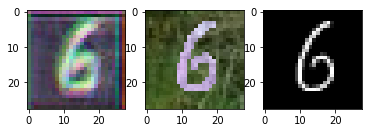

Batch 231/1072
Updating approximate labels. Best label accuracy: 0.5390
Batch 247/1072
Updating approximate labels. Best label accuracy: 0.5460
Batch 265/1072
Updating approximate labels. Best label accuracy: 0.5510
Batch 272/1072
Updating approximate labels. Best label accuracy: 0.5530
Batch 283/1072
Updating approximate labels. Best label accuracy: 0.5560
Batch 321/1072
Updating approximate labels. Best label accuracy: 0.5620
Batch 325/1072
Updating approximate labels. Best label accuracy: 0.5740
Batch 379/1072
Updating approximate labels. Best label accuracy: 0.5790
Batch 400/1072 - 1005s - d_mnist: 0.0842 - d_mnist_m: 0.1600 - g-d: 0.3323 - g-c: 0.0446 - mnist_m_val_acc: 0.5400


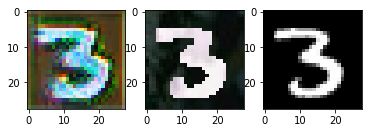

Batch 528/1072
Updating approximate labels. Best label accuracy: 0.5830
Batch 600/1072 - 1515s - d_mnist: 0.1082 - d_mnist_m: 0.0703 - g-d: 0.4962 - g-c: 0.0685 - mnist_m_val_acc: 0.5590


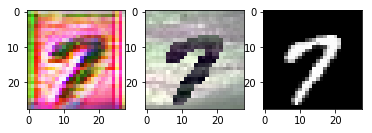

Batch 746/1072
Updating approximate labels. Best label accuracy: 0.5860
Batch 771/1072
Updating approximate labels. Best label accuracy: 0.5990
Batch 800/1072 - 2022s - d_mnist: 0.0873 - d_mnist_m: 0.0882 - g-d: 0.4587 - g-c: 0.0442 - mnist_m_val_acc: 0.5620


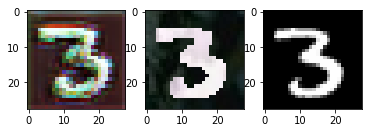

Batch 824/1072
Updating approximate labels. Best label accuracy: 0.6020
Batch 899/1072
Updating approximate labels. Best label accuracy: 0.6140
Batch 927/1072
Updating approximate labels. Best label accuracy: 0.6310
Batch 971/1072
Updating approximate labels. Best label accuracy: 0.6420
Batch 1000/1072 - 2537s - d_mnist: 0.1477 - d_mnist_m: 0.0481 - g-d: 0.4876 - g-c: 0.0413 - mnist_m_val_acc: 0.6010


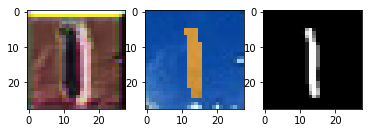

Batch 1015/1072
Updating approximate labels. Best label accuracy: 0.6480
Batch 1031/1072
Updating approximate labels. Best label accuracy: 0.6550
Batch 1048/1072
Updating approximate labels. Best label accuracy: 0.6560
Batch 1059/1072
Updating approximate labels. Best label accuracy: 0.6570
Batch 1063/1072
Updating approximate labels. Best label accuracy: 0.6590
Batch 1070/1072
Updating approximate labels. Best label accuracy: 0.6690
Batch 1072/1072
Epoch 2/4
Batch 59/1072
Updating approximate labels. Best label accuracy: 0.6750
Batch 92/1072
Updating approximate labels. Best label accuracy: 0.6840
Batch 120/1072
Updating approximate labels. Best label accuracy: 0.6970
Batch 142/1072
Updating approximate labels. Best label accuracy: 0.7040
Batch 193/1072
Updating approximate labels. Best label accuracy: 0.7060
Batch 197/1072
Updating approximate labels. Best label accuracy: 0.7090
Batch 200/1072 - 517s - d_mnist: 0.1124 - d_mnist_m: 0.0897 - g-d: 0.6256 - g-c: 0.0488 - mnist_m_val_acc:

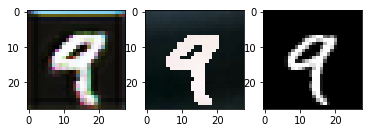

Batch 207/1072
Updating approximate labels. Best label accuracy: 0.7120
Batch 253/1072
Updating approximate labels. Best label accuracy: 0.7150
Batch 400/1072 - 1026s - d_mnist: 0.1071 - d_mnist_m: 0.1355 - g-d: 0.4669 - g-c: 0.0548 - mnist_m_val_acc: 0.6970


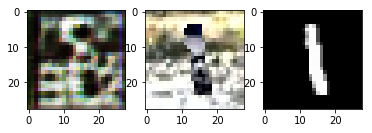

Batch 475/1072
Updating approximate labels. Best label accuracy: 0.7270
Batch 600/1072 - 1538s - d_mnist: 0.1363 - d_mnist_m: 0.1249 - g-d: 0.7865 - g-c: 0.0709 - mnist_m_val_acc: 0.6960


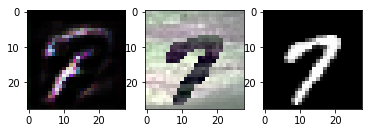

Batch 773/1072
Updating approximate labels. Best label accuracy: 0.7340
Batch 800/1072 - 2050s - d_mnist: 0.0866 - d_mnist_m: 0.2598 - g-d: 0.3212 - g-c: 0.0689 - mnist_m_val_acc: 0.6860


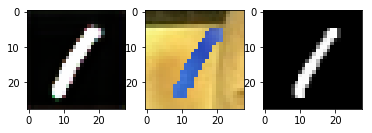

Batch 905/1072
Updating approximate labels. Best label accuracy: 0.7360
Batch 946/1072
Updating approximate labels. Best label accuracy: 0.7390
Batch 952/1072
Updating approximate labels. Best label accuracy: 0.7400
Batch 1000/1072 - 2568s - d_mnist: 0.1652 - d_mnist_m: 0.1551 - g-d: 0.6973 - g-c: 0.0491 - mnist_m_val_acc: 0.7230


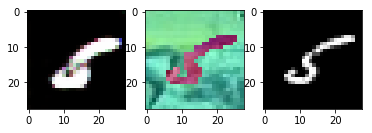

Batch 1072/1072
Epoch 3/4
Batch 54/1072
Updating approximate labels. Best label accuracy: 0.7450
Batch 68/1072
Updating approximate labels. Best label accuracy: 0.7460
Batch 70/1072
Updating approximate labels. Best label accuracy: 0.7490
Batch 114/1072
Updating approximate labels. Best label accuracy: 0.7500
Batch 138/1072
Updating approximate labels. Best label accuracy: 0.7540
Batch 155/1072
Updating approximate labels. Best label accuracy: 0.7600
Batch 200/1072 - 514s - d_mnist: 0.1082 - d_mnist_m: 0.2343 - g-d: 0.4570 - g-c: 0.0451 - mnist_m_val_acc: 0.7500


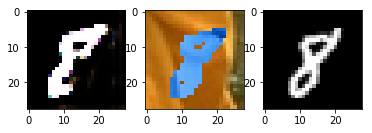

Batch 353/1072
Updating approximate labels. Best label accuracy: 0.7630
Batch 400/1072 - 1030s - d_mnist: 0.1105 - d_mnist_m: 0.1778 - g-d: 0.5118 - g-c: 0.0729 - mnist_m_val_acc: 0.7320


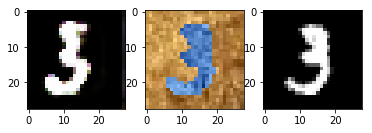

Batch 567/1072
Updating approximate labels. Best label accuracy: 0.7640
Batch 600/1072 - 1539s - d_mnist: 0.1133 - d_mnist_m: 0.1403 - g-d: 0.5083 - g-c: 0.0850 - mnist_m_val_acc: 0.7290


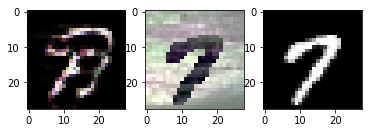

Batch 625/1072
Updating approximate labels. Best label accuracy: 0.7650
Batch 796/1072
Updating approximate labels. Best label accuracy: 0.7670
Batch 800/1072 - 2054s - d_mnist: 0.0429 - d_mnist_m: 0.2427 - g-d: 0.2206 - g-c: 0.0947 - mnist_m_val_acc: 0.7620


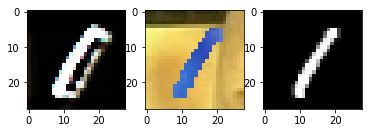

Batch 820/1072
Updating approximate labels. Best label accuracy: 0.7730
Batch 1000/1072 - 2568s - d_mnist: 0.1748 - d_mnist_m: 0.0993 - g-d: 0.6893 - g-c: 0.0381 - mnist_m_val_acc: 0.7510


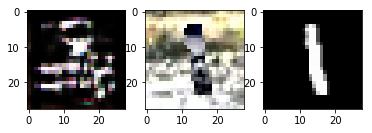

Batch 1072/1072
Epoch 4/4
Batch 24/1072
Updating approximate labels. Best label accuracy: 0.7740
Batch 99/1072
Updating approximate labels. Best label accuracy: 0.7750
Batch 200/1072 - 516s - d_mnist: 0.1159 - d_mnist_m: 0.0772 - g-d: 0.4261 - g-c: 0.0429 - mnist_m_val_acc: 0.7490


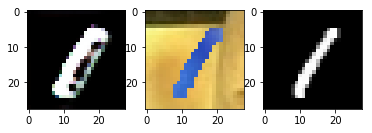

Batch 400/1072 - 1031s - d_mnist: 0.0809 - d_mnist_m: 0.1060 - g-d: 0.5454 - g-c: 0.0599 - mnist_m_val_acc: 0.7660


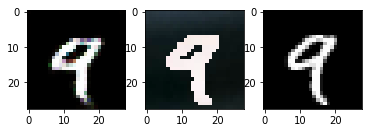

Batch 600/1072 - 1546s - d_mnist: 0.1519 - d_mnist_m: 0.0911 - g-d: 0.5232 - g-c: 0.0861 - mnist_m_val_acc: 0.7380


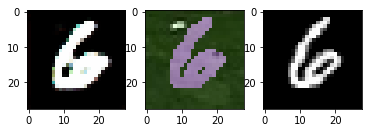

Batch 800/1072 - 2057s - d_mnist: 0.0855 - d_mnist_m: 0.2739 - g-d: 0.2418 - g-c: 0.0648 - mnist_m_val_acc: 0.7340


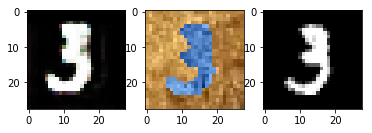

Batch 1000/1072 - 2570s - d_mnist: 0.2378 - d_mnist_m: 0.1174 - g-d: 0.6913 - g-c: 0.0400 - mnist_m_val_acc: 0.7460


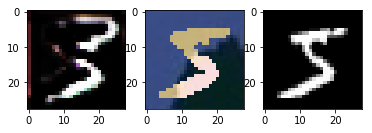

Batch 1072/1072

In [3]:
# helper function to one-hot-encode target variables
def one_hot_encode(y, n_class):
    return np.eye(np.array(n_class))[y]

# obtain approximate labels for target set
y_appr = one_hot_encode(t_classes, 10)
X_val = Variable(torch.from_numpy(Xt_test[:1000]))

# create lists for losses and accuracies
acc_vec = []
d_loss_vec = []
c_loss_vec = []
update_iter = []
best_acc = lower_lim

# train the approximate label matcher model
print('\n\nTraining discriminator and generator..')
for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    start_time = time.time()
    
    # prepare source and target batch
    source_gen = batch_generator(batch_size, Xs_train, ys_train)
    target_gen = batch_generator(batch_size, Xt_train, yt_train)
    
    # iterate over batches
    for i, (Xs, _, split_idx) in enumerate(source_gen):
        Xt, _, split_idx = next(target_gen)
        
        y_ones = Variable(torch.ones((len(Xt), 1)))     # ones for source
        y_zeros = Variable(torch.zeros((len(Xt), 1)))   # zeros for target
        
        # failsafe for batch generator
        if len(split_idx) != batch_size:
            continue

        # get approx labels for batch
        y_approx = Variable(torch.from_numpy(y_appr[split_idx]))

        # 1) TRAIN THE DISCRIMINATOR
        D.zero_grad()

        # 1a) Train the discriminator on source images
        d_out = D(Xs)
        d_source_loss = bce_crit(d_out, y_ones) * l
        d_source_loss.backward(retain_variables=True)


        # 1b) Train the discriminator on target images
        d_out = D(G(Xt))
        d_target_loss = bce_crit(d_out, y_zeros) * l
        d_target_loss.backward(retain_variables=True)
        d_optimizer.step()

        # 2) TRAIN THE GENERATOR
        G.zero_grad()

        # 2a) Train the generator on discriminator response
        d_out = D(G(Xt))
        g_d_loss = bce_crit(d_out, y_ones) * l   # fool discriminator (ones for target)
        g_d_loss.backward(retain_variables=True)
        g_optimizer.step()

        # 2b) Train the generator on classifier response
        G.zero_grad()

        c_out = C(G(Xt))
        g_c_loss = mse_crit(c_out, y_approx.float()) * (1 - l)
        g_c_loss.backward(retain_variables=True)
        g_optimizer.step()


        # 3) Print losses and target validation accuracy
        Y_val = C(G(X_val))
        _, t_classes = Y_val.max(1)
        acc = accuracy_score(y_true=[np.argmax(i) for i in yt_test[:1000]], y_pred=t_classes.data.numpy().ravel())
        
        if (i+1) % print_interval == 0:
            print(' - {}s - d_{}: {} - d_{}: {} - g-d: {} - g-c: {} - {}_val_acc: {}\n'.format(
                        round(time.time() - start_time),
                        source_data, format(d_source_loss.data[0], '.4f'), 
                        target_data, format(d_target_loss.data[0], '.4f'), 
                        format(g_d_loss.data[0], '.4f'),
                        format(g_c_loss.data[0], '.4f'),
                        target_data, format(acc, '.4f')), end='')
        
        
        # save losses to vector
        acc_vec.append(float(format(acc, '.4f')))
        d_loss_vec.append(float(format(g_d_loss.data[0], '.4f')))
        c_loss_vec.append(float(format(g_c_loss.data[0], '.4f')))

        # iterative label matching method
        if method == 'selective':
            # remember best acc with labels
            new_best = np.max([np.max(acc_vec), lower_lim])
            if new_best > best_acc:
                print('\nUpdating approximate labels. Best label accuracy: {}'.format(format(new_best, '.4f')))

                # update approximate labels
                del Ystar
                Ystar = C(Variable(torch.from_numpy(Xt_train)))
                t_classes = Ystar.max(1)[1].data.numpy().ravel()
                y_appr = one_hot_encode(t_classes, 10)

                # remember new best accuracy and save iteration of update
                best_acc = new_best
                update_iter.append(int((epoch*i)+i))
        
        # continuous label update method
        if method == 'iterative':
            del Ystar
            Ystar = C(Variable(torch.from_numpy(Xt_train)))
            t_classes = Ystar.max(1)[1].data.numpy().ravel()
            y_appr = one_hot_encode(t_classes, 10)

        # plot example images
        if (i+1) % print_interval == 0:
            plot_imgs(G, Xt_train, Xs_train)

In [4]:
import pandas as pd
from math import factorial


def sg_filter(y, window_size=101, order=3, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1:half_window+1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

def plot_loss(title, acc, dloss, closs, smoothen=False):
    if smoothen:
        acc = sg_filter(np.array(acc))
        dloss = sg_filter(np.array(dloss))
        closs = sg_filter(np.array(closs))
    fig, ax = plt.subplots()
    ax.plot(range(len(acc)), acc, label='t_val_acc')
    ax.plot(range(len(acc)), dloss, label='d_loss')
    ax.plot(range(len(acc)), closs, label='c_loss')
    legend = ax.legend(loc='center right')
    plt.title(title)

df = pd.DataFrame({'acc':acc_vec, 'd_loss':d_loss_vec, 'c_loss':c_loss_vec})

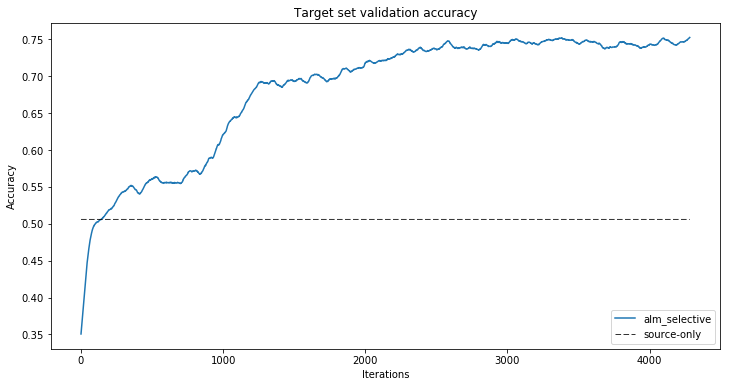

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(range(len(df.acc)), sg_filter(np.array(df.acc)), label='alm_selective')
ax.plot(range(len(df.acc)), np.repeat(0.506, len(df.acc)), 'k--',label='source-only', linewidth=0.8)
legend = ax.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Target set validation accuracy')
plt.show()

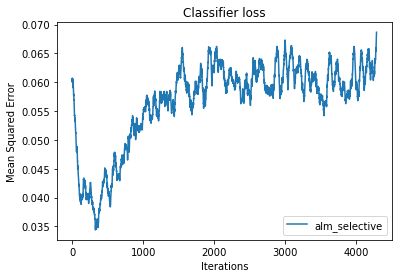

In [9]:
fig, ax = plt.subplots()
ax.plot(range(len(df.acc)), sg_filter(np.array(df.c_loss)), label='alm_selective')
legend = ax.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Classifier loss')
plt.show()

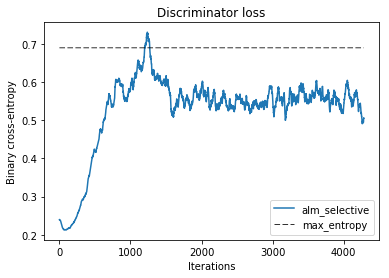

In [11]:
fig, ax = plt.subplots()
ax.plot(range(len(df.acc)), sg_filter(np.array(df.d_loss)), label='alm_selective')
ax.plot(range(len(df.acc)), np.repeat(0.69, len(df.acc)), 'k--', label='max_entropy', linewidth=0.8)
legend = ax.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Binary cross-entropy')
plt.title('Discriminator loss')
plt.show()

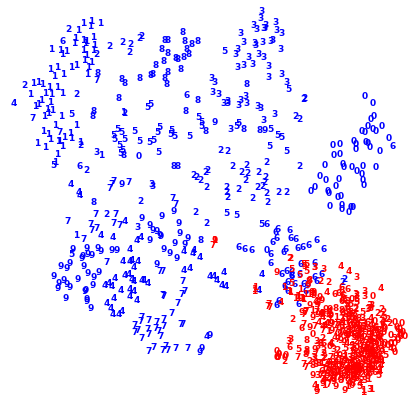

In [12]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# function to plot dataset embeddings
def plot_embedding(x, y, d, title=None):
    plt.figure(figsize=(7, 7), frameon=False)
    plt.subplot(111)
    for i in range(x.shape[0]):
        plt.text(x[i, 0], x[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    if title is not None:
        plt.title(title)

def norm_img(x):
    return ((x - np.min(x))) / (np.max(x) - np.min(x))

xt_train = np.mean(Xt_train, axis=1).reshape((Xt_train.shape[0], -1))[:500]
xs_train = np.mean(Xs_train, axis=1).reshape((Xs_train.shape[0], -1))[:500]
    
tsne = TSNE(n_components=2, init='pca', random_state=0)
xs_tsne = norm_img(tsne.fit_transform(xs_train))
xt_tsne = norm_img(tsne.fit_transform(xt_train))

x_tsne = np.concatenate((xs_tsne, xt_tsne)) 
class_lab = np.concatenate((ys_train[:500].argmax(1), yt_train[:500].argmax(1)))
domain_lab = np.concatenate((np.repeat(0, len(xs_tsne)), np.repeat(1, len(xt_tsne))))
    
plot_embedding(x_tsne, class_lab, domain_lab)

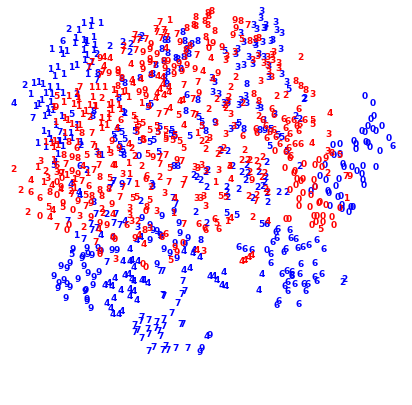

In [13]:
xt_train = G(Variable(torch.from_numpy(Xt_train[:500])))
xt_train = np.mean(xt_train.data.numpy(), axis=1).reshape((500, -1))
xs_train = np.mean(Xs_train, axis=1).reshape((Xs_train.shape[0], -1))[:500]

tsne = TSNE(n_components=2, init='pca', random_state=0)
xs_tsne = norm_img(tsne.fit_transform(xs_train))
xt_tsne = norm_img(tsne.fit_transform(xt_train))

x_tsne = np.concatenate((xs_tsne, xt_tsne)) 
class_lab = np.concatenate((ys_train[:500].argmax(1), yt_train[:500].argmax(1)))
domain_lab = np.concatenate((np.repeat(0, len(xs_tsne)), np.repeat(1, len(xt_tsne))))
    
plot_embedding(x_tsne, class_lab, domain_lab)